## 第二章: 端對端機器學習專案

In [96]:
import os
import tarfile
import urllib.request
import numpy as np
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

`os.mkdir` 與 `os.makedirs` 都是用來建立新目錄的函數，但是有幾個差異：

1. `os.mkdir` 只能建立一層目錄，若目錄的上層目錄不存在，則會拋出 FileNotFoundError 的異常，因此必須先建立上層目錄才能使用此函數。
而 `os.makedirs` 則可以建立多層目錄，若上層目錄不存在，則會自動建立。

2. `os.mkdir` 的函數原型為 `os.mkdir(path, mode=0o777, *, dir_fd=None)`，其中 `mode` 參數可以指定新建目錄的權限。而 `os.makedirs` 的函數原型為 `os.makedirs(name, mode=0o777, exist_ok=False)`, 其中 `exist_ok` 參數為 False 時，如果目錄已經存在，則會拋出 FileExistsError 的異常。

因此，如果需要建立多層目錄或是確定上層目錄已存在，建議使用 `os.makedirs`。反之，若只需建立一層目錄且確定上層目錄已存在，則可以使用 `os.mkdir`。

In [97]:
# code to save fig as high resolution png for the book
import matplotlib.pyplot as plt
IMAGES_PATH = os.path.join('images', 'Chapter 2 end to end project')
os.makedirs(IMAGES_PATH, exist_ok=True)

params = {
   'font.size': 14,
   'axes.labelsize': 14,
   'axes.titlesize': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
}

plt.rcParams.update(params)

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300, update=False):
    filename = f"{fig_name}.{fig_extension}"
    path = os.path.join(IMAGES_PATH, f"{fig_name}.{fig_extension}")
    if tight_layout:
        plt.tight_layout()
    if update or not os.path.isfile(path):
        plt.savefig(path, format=fig_extension, dpi=resolution)
    else:
        print(f"File '{filename}' already exists, use 'update=True' to overwrite")

In [98]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # make directory if not exist
    # exist_ok=True means if the directory already exist, it won't raise an error
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")

    # Download file from housing_url and save it to tgz_path location in local file system
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [99]:
# fetch_housing_data()

In [100]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [101]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [102]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [103]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


File 'attribute_histogram_plots.png' already exists, use 'update=True' to overwrite


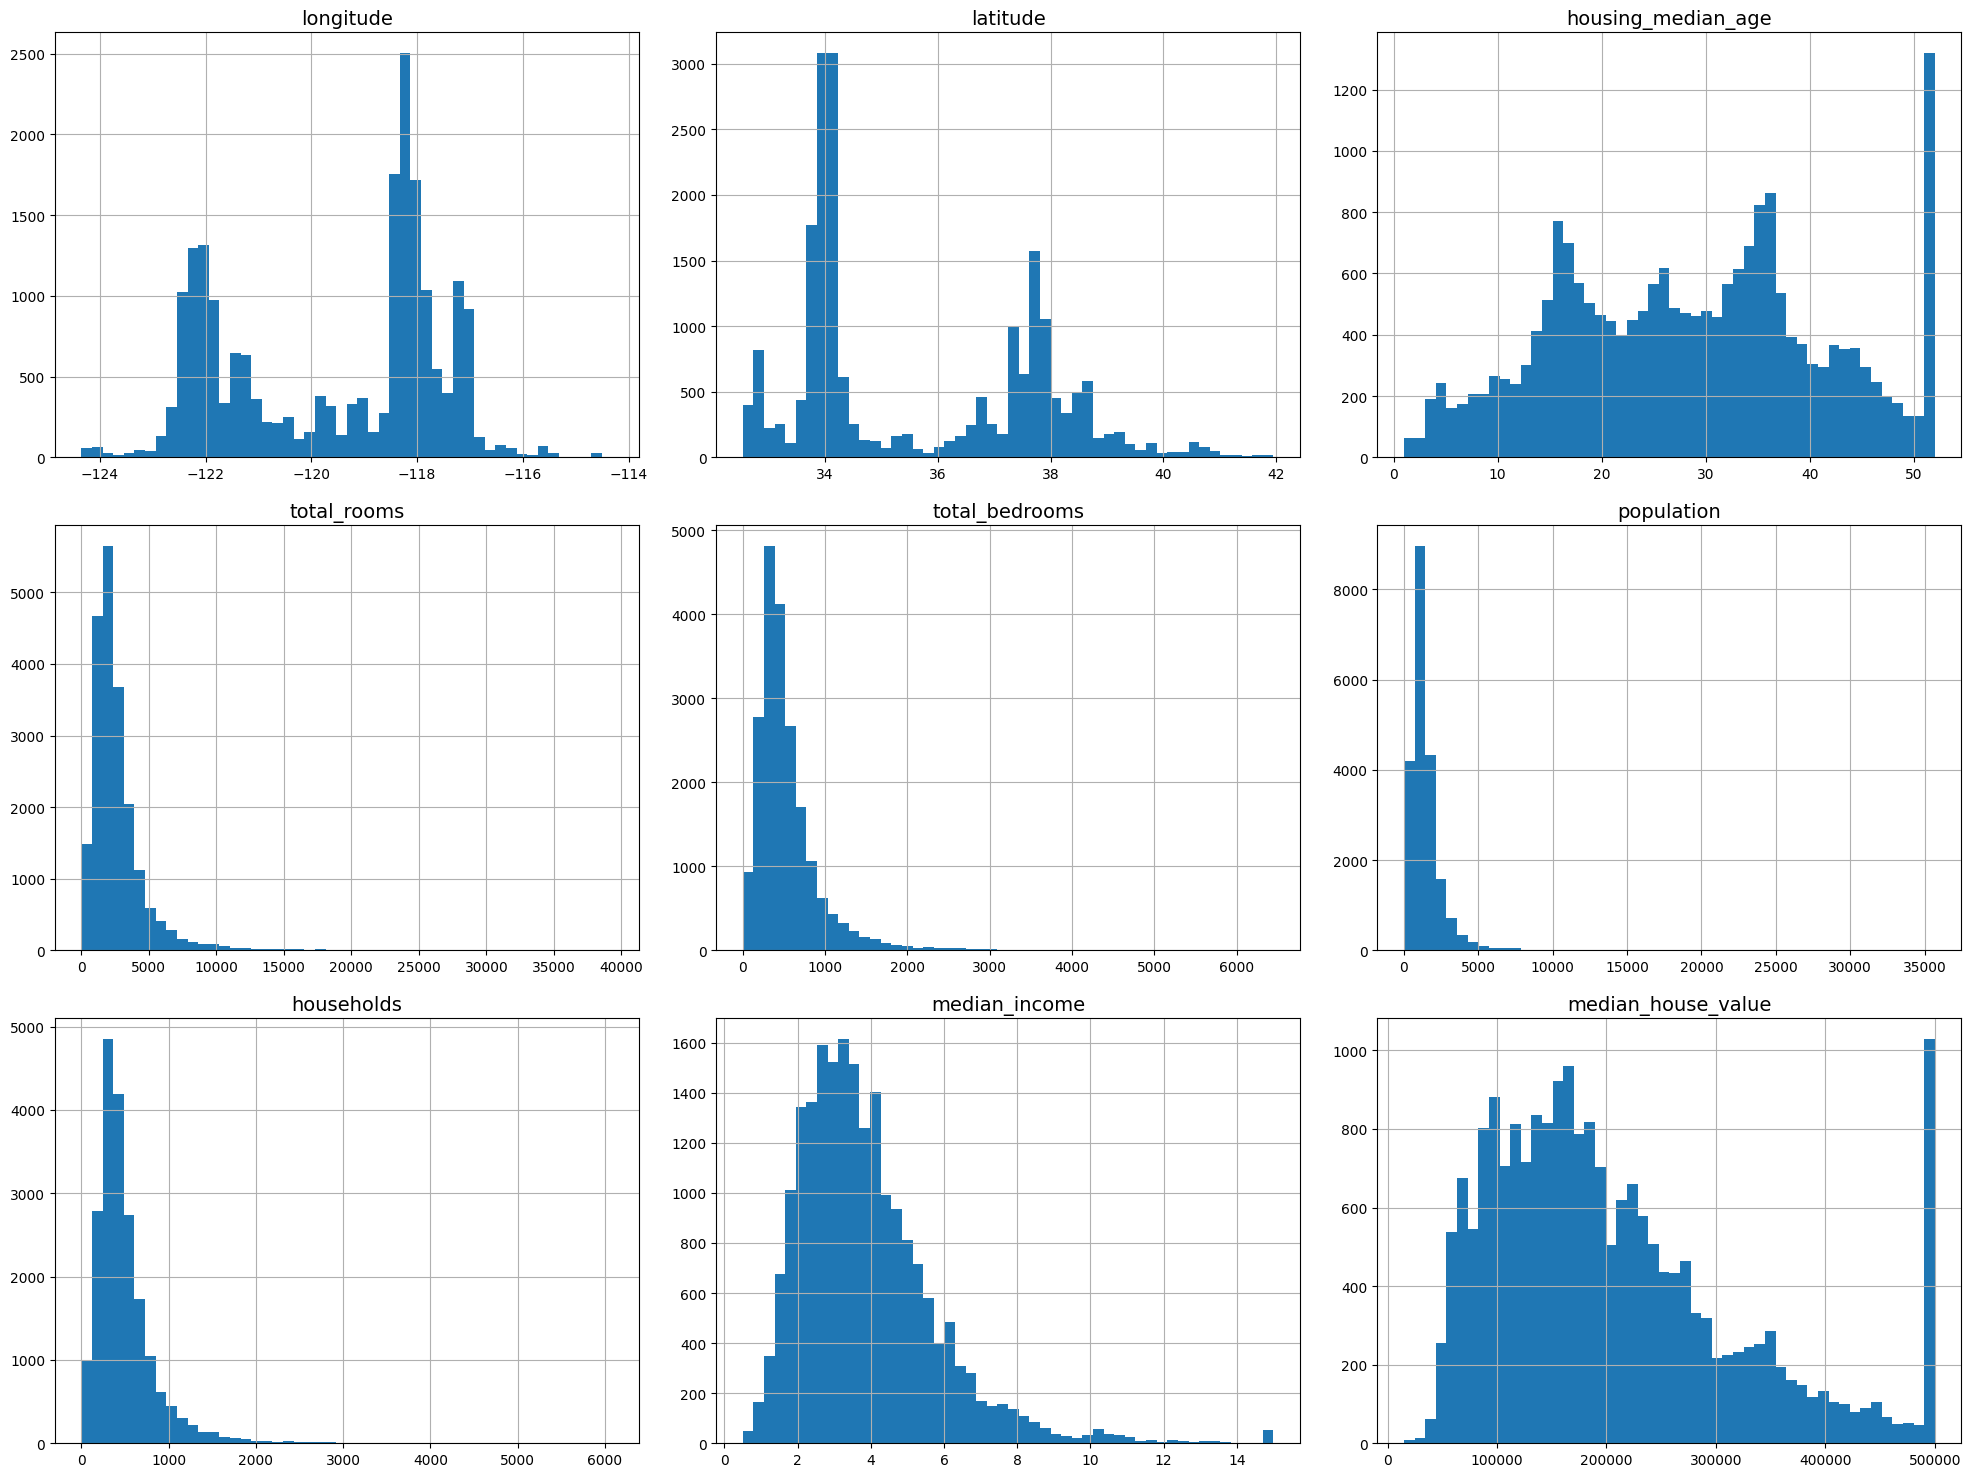

In [104]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

This video provides a brief introduction to how crc32 works: https://www.youtube.com/watch?v=1NlzKh9e4Gs. 

You can also check out the Wikipedia page on crc32 at https://en.wikipedia.org/wiki/Cyclic_redundancy_check.


In [105]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [106]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, test_ratio=0.2, id_column="index")

In [107]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [108]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [109]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [110]:
# import train test split
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_with_id, test_size=0.2, random_state=42)

In [111]:
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0. , 1.5, 3. , 4.5, 6. , np.inf], labels=[1, 2, 3, 4, 5])

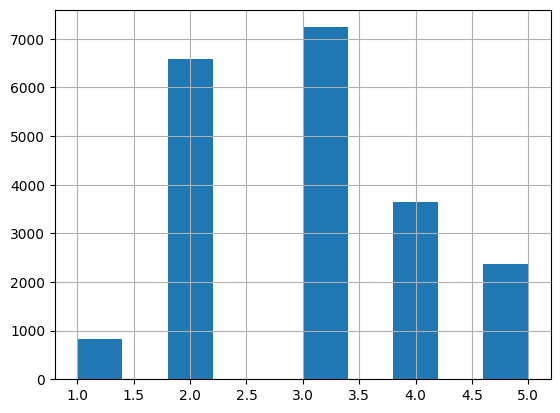

In [112]:
housing['income_cat'].hist()
plt.show()

`n_splits=1`: 分割成幾組，這裡指定為 1 組\
`test_size=0.2`: 分割出的測試集比例為 20%\
`random_state=42`: 設定隨機種子，確保每次執行時結果相同

In [113]:
from sklearn.model_selection import StratifiedShuffleSplit

# n_splits=1: 分割成幾組，這裡指定為 1 組
# test_size=0.2: 分割出的測試集比例為 20%
# random_state=42: 設定隨機種子，確保每次執行時結果相同
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

`StratifiedShuffleSplit.split()` 回傳的是一個 generator，所以可以用 `for` 迴圈依序取出多組訓練集和測試集。\
當然也可以用`train_index, test_index = next(split.split(housing, housing['income_cat']))`

In [114]:
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [115]:
strat_test_set['income_cat'].value_counts(normalize=True)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: proportion, dtype: float64

In [117]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
compare_props = pd.DataFrame({
    "Overall %": housing['income_cat'].value_counts(normalize=True),
    "Stratified %": strat_test_set['income_cat'].value_counts(normalize=True),
    "Random %": test_set['income_cat'].value_counts(normalize=True),
}).sort_index()
compare_props.index.name = 'Income Category'
compare_props['Strat Error %'] = compare_props['Stratified %']/compare_props['Overall %'] - 1
compare_props['Random Error %'] = compare_props['Random %']/compare_props['Overall %'] - 1
(compare_props*100).round(2)

,Overall %,Stratified %,Random %,Strat Error %,Random Error %
Income Category,,,,,
1,3.98,4.00,4.02,0.36,0.97
2,31.88,31.88,32.44,-0.02,1.73
3,35.06,35.05,35.85,-0.01,2.27
4,17.63,17.64,16.74,0.03,-5.06
5,11.44,11.43,10.95,-0.08,-4.32


使用 `set_` 的目的是區別變數名稱與 set 這個 Python 內建函數。此外，在 for 迴圈中我們只是需要暫時用到 `strat_train_set` 和 `strat_test_set` 這兩個變數，因此使用底線後綴表示這些變數是暫時的，不需要保存到後面的操作中。

In [118]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

`pd.DataFrame.copy()` 方法的預設行為是進行深拷貝，也就是 `deep=True`。

In [119]:
housing = strat_train_set.copy()

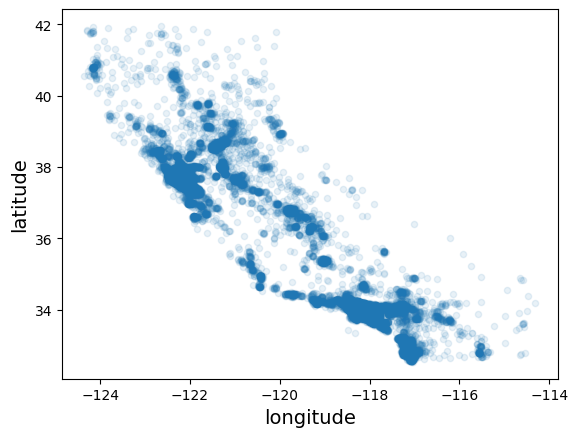

In [120]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

`s` 參數代表著每個點的半徑大小，`c` 參數代表著每個點的顏色。\
`s` 參數被設定為 `housing['population']/100`，使用每個點所代表城市的人口數來調整點的大小。\
`c` 參數被設定為 `median_house_value`，使用每個點所代表城市的房屋價格中位數來調整點的顏色。

File 'housing_price_scatterplot.png' already exists, use 'update=True' to overwrite


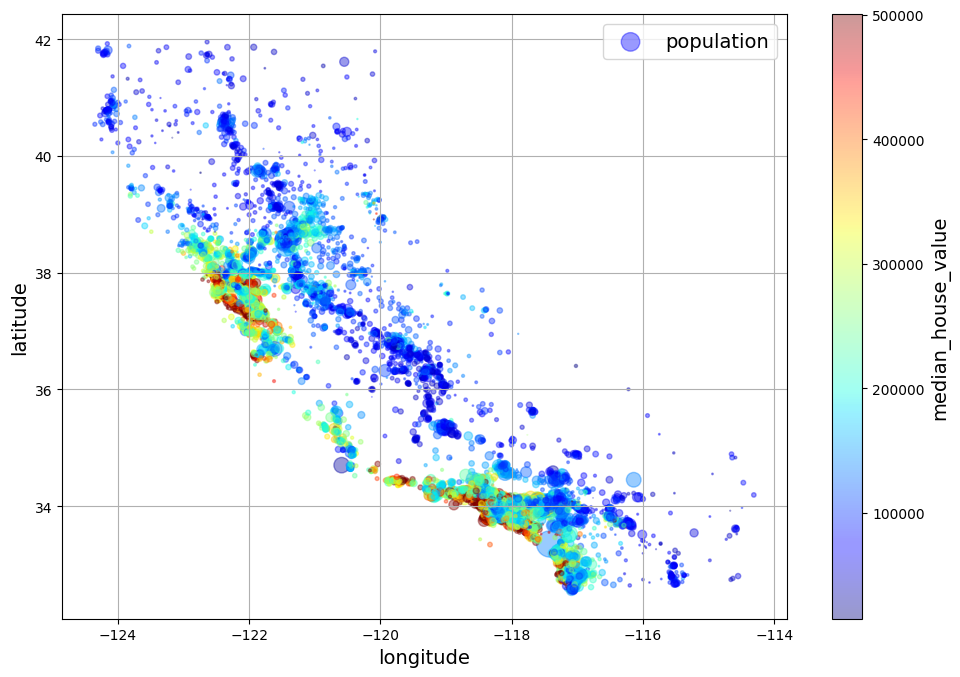

In [148]:
housing.plot(kind='scatter', x='longitude', y='latitude', s=housing['population']/100, 
             alpha = 0.4, c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             legend=True, grid=True, label='population', figsize=(10,7))
save_fig('housing_price_scatterplot')
plt.show()

In [122]:
corr_matrix = housing.corr(numeric_only=True)

In [123]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

File 'california_housing_prices_plot.png' already exists, use 'update=True' to overwrite


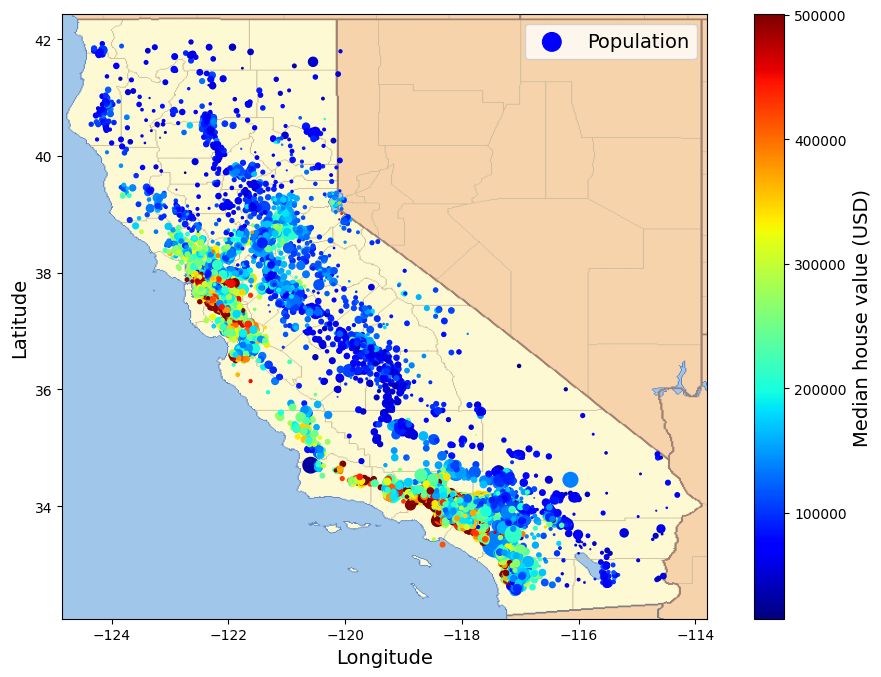

In [150]:
import matplotlib.pyplot as plt
filename = 'california.png'
if not os.path.isfile(os.path.join(IMAGES_PATH, filename)):
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print('Downloading', filename)
    urllib.request.urlretrieve(url, os.path.join(IMAGES_PATH, filename))

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude",
                     s=housing_renamed['Population'] / 100, label="Population",
                     c="Median house value (USD)", cmap="jet", colorbar=True,
                     legend=True, figsize=(10,7))

california_img = plt.imread(os.path.join(IMAGES_PATH, filename))
plt.imshow(california_img, extent=[*plt.gca().get_xlim(), *plt.gca().get_ylim()])
save_fig('california_housing_prices_plot')
plt.show()

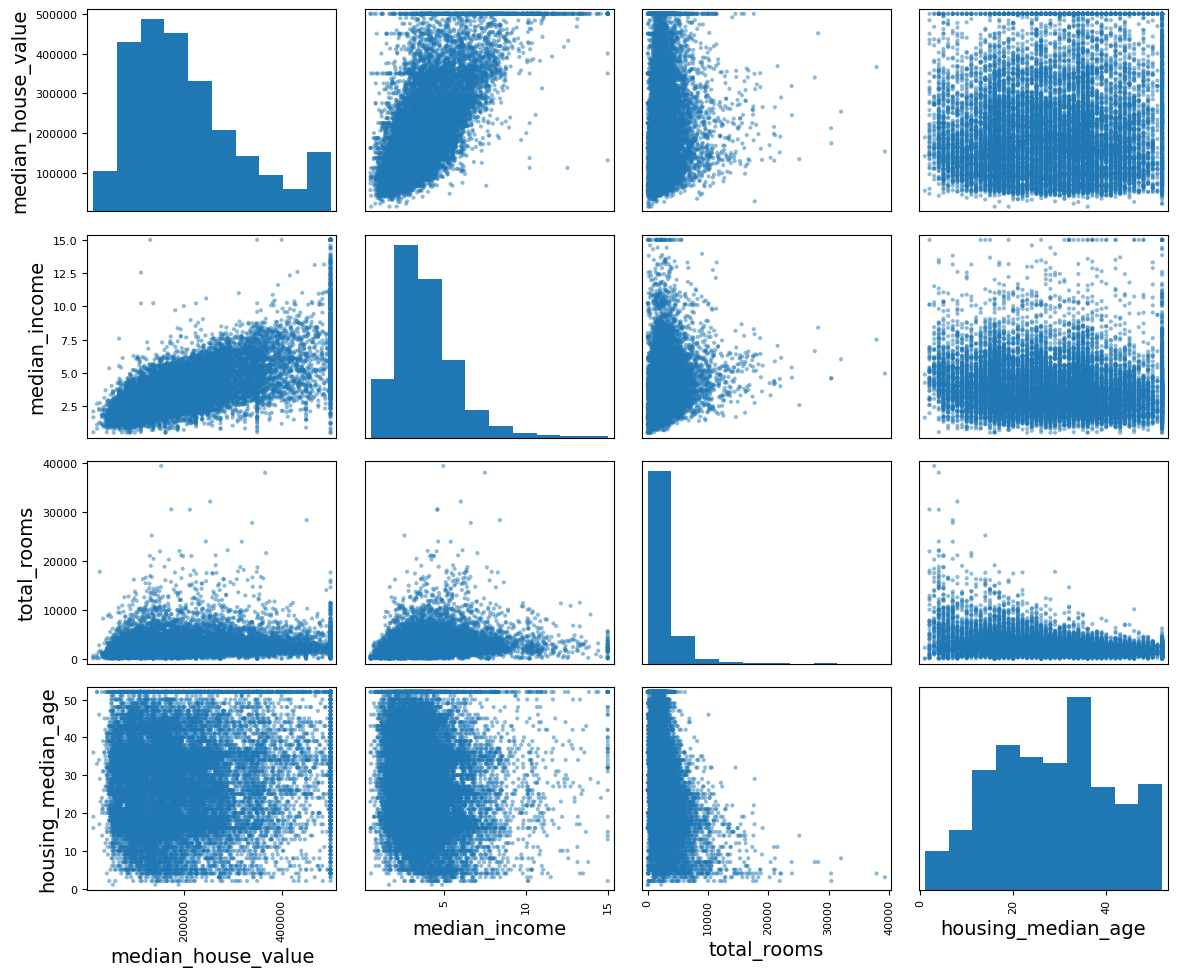

In [156]:
from pandas.plotting import scatter_matrix
attributes = attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,10))
save_fig('scatter_matrix_plot')
plt.show()

我們發現有強相關性，另外median_house_value在500000被截斷。

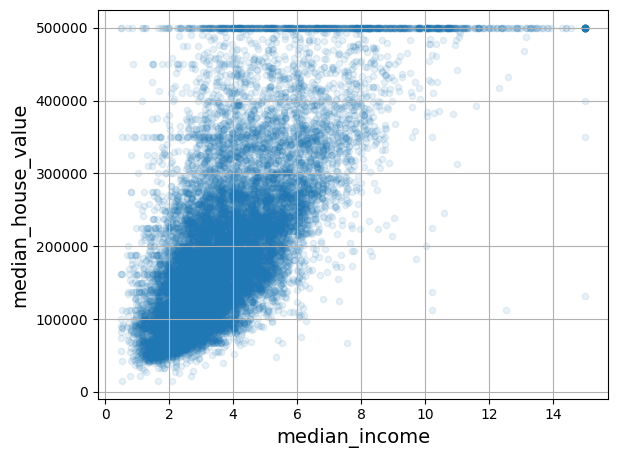

In [157]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)
save_fig('income_vs_house_value_scatterplot')
plt.show()

In [159]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [160]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.687151
rooms_per_household    0.146255
total_rooms            0.135140
housing_median_age     0.114146
households             0.064590
total_bedrooms         0.047781
people_per_house      -0.021991
population            -0.026882
longitude             -0.047466
latitude              -0.142673
bedrooms_ratio        -0.259952
Name: median_house_value, dtype: float64

In [163]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value']

+ 刪除 "ocean_proximity" 欄位中含有缺失值的資料列 \
    `housing.dropna(subset=["ocean_proximity"])` 
+ 刪除名為 "ocean_proximity" 的欄位，若欄位含有缺失值也會被刪除\
    `housing.dropna('ocean_proximity', axis=1)`
+ 將 "total_bedrooms" 欄位中的缺失值以該欄位的中位數進行填補
    `housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)`

In [ ]:
housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)

`strategy` in `SimpleImputer`
+ `mean`
+ `median`
+ `most_frequent`
+ `constant`

In [170]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [172]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [184]:
# 各個變數的median
print('imputer result', imputer.statistics_, sep=':\n')
print('pandas result', housing_num.median(axis=0).values, sep=':\n')

imputer result:
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
manual result:
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [186]:
import pandas as pd
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

Outlier detection

In [196]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [198]:
# housing = housing.iloc[outlier_pred == 1]
# housing_labels = housing_labels.iloc[outlier_pred == 1]

In [199]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
12655,INLAND
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY


In [200]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

當初被分類的categories都被保留在encoder裡面(sklearn裡的API幾乎都有這樣的特性)

In [201]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [202]:
onehotencoder = OneHotEncoder()
housing_cat_onehot = onehotencoder.fit_transform(housing_cat)

In [203]:
onehotencoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

你會發現 `housing_cat_onehot` 只會告訴你是稀疏矩陣，因為本來裡面就很多0，這樣可以節省記憶體空間，並且可以像一般的2D array一樣使用。

In [204]:
housing_cat_onehot

<14396x5 sparse matrix of type '<class 'numpy.float64'>'
	with 14396 stored elements in Compressed Sparse Row format>

如果真的想要把他轉回2D array的話，可以用toarray

In [205]:
housing_cat_onehot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])